# Setup

In [1]:
DATA_VERSION = "2025-07-07"
DATA_FILE_NAME = f"consultation-documents-preprocessed-{DATA_VERSION}.parquet"
EMBEDDINGS_FILE_NAME = (
    f"consultation-documents-embeddings-beginnings-openai-text-embedding-3-large-{DATA_VERSION}.parquet"
)


LANGUAGES = {
    "de",
    # "fr",
    # "it",
}
TOPIC_LABEL_SOURCES = {
    "openparldata",
    # "organisation_rule",
    "manual",
}

# FROM_YEAR = 2010
FROM_YEAR = 2000

MIN_CONSULTATIONS_IN_CLASS = 40
IGNORE_TOPICS = {
    # "administration",
    # "communications",
}

DOC_TYPES = {
    "DRAFT",
    None,  # Many openparldata documents don't have a known type
    # "VARIOUS_TEXT",
    # "LETTER",
    # "RECIPIENT_LIST",  # proven to not be useful
    # "REPORT",
    # "FINAL_REPORT",
    # "OPINION",
    # "SYNOPTIC_TABLE",  # possibly not useful?
    # "SURVEY",
    # "RESPONSE_FORM",
}

CV_FOLDS = 5
TEST_SIZE = 0.1
RANDOM_STATE = 271

In [2]:
%load_ext autoreload
%autoreload 2

import logging
import pathlib
import sys
from typing import Any

import dotenv
import mlflow
import numpy as np
import pandas as pd
import sklearn.metrics
import sklearn.model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

REPOSITORY_ROOT = (pathlib.Path().cwd() / ".." / "..").resolve()
sys.path.append(str(REPOSITORY_ROOT))

In [3]:
from research.lib import data_access, data_transformations, plotting, stratified_group_split, utils

In [4]:
dotenv.load_dotenv()
utils.set_up_logging_and_mlflow("VM_document_topic_classifier")

mlflow.log_param("data_version", DATA_VERSION)
mlflow.log_param("input_file", DATA_FILE_NAME)
mlflow.log_param("embeddings_file", EMBEDDINGS_FILE_NAME)
mlflow.log_param("topic_label_sources", sorted(TOPIC_LABEL_SOURCES))
mlflow.log_param("languages", LANGUAGES)
mlflow.log_param("from_year", FROM_YEAR)
mlflow.log_param("min_consultations_in_class", MIN_CONSULTATIONS_IN_CLASS)
mlflow.log_param("ignore_topics", sorted(IGNORE_TOPICS))
mlflow.log_param("doc_types", sorted(map(str, DOC_TYPES)))
mlflow.log_param("cv_folds", CV_FOLDS)
mlflow.log_param("test_size", TEST_SIZE)
mlflow.log_param("random_state", RANDOM_STATE)
;

INFO research.lib.utils: MLflow tracking to https://mlflow.ml1.demokratis.ch/
INFO research.lib.utils: Starting run = upbeat-steed-595


''

In [5]:
mlflow.sklearn.autolog()
tqdm.pandas()

2025/07/07 14:44:55 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.6.1, but the installed version is 1.7.0. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.


# Input data preparation

In [6]:
PREPROCESSED_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / DATA_FILE_NAME
data_access.ensure_dataframe_is_available(PREPROCESSED_DATA_FILE)
EMBEDDINGS_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / EMBEDDINGS_FILE_NAME
data_access.ensure_dataframe_is_available(EMBEDDINGS_DATA_FILE)

INFO download_file_from_exoscale: Downloading dataframes/consultation-documents-preprocessed-2025-07-07.parquet from bucket demokratis-ml to /Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-preprocessed-2025-07-07.parquet
INFO download_file_from_exoscale: Downloading dataframes/consultation-documents-embeddings-beginnings-openai-text-embedding-3-large-2025-07-07.parquet from bucket demokratis-ml to /Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-embeddings-beginnings-openai-text-embedding-3-large-2025-07-07.parquet


In [7]:
df_docs = data_access.load_consultation_documents(
    PREPROCESSED_DATA_FILE,
    only_languages=LANGUAGES,
    only_doc_types=DOC_TYPES,
    starting_year=FROM_YEAR,
    mlflow=mlflow,
)
df_docs = df_docs[df_docs["consultation_topics_label_source"].isin(TOPIC_LABEL_SOURCES)]
df_docs

,document_uuid,consultation_identifier,consultation_start_date,consultation_end_date,consultation_title,consultation_description,document_source_url,consultation_url,consultation_topics,consultation_internal_tags,...,organisation_name,political_body,latest_stored_file_uuid,document_source,consultation_topics_label_source,document_type_label_source,document_content_plain,stored_file_path,stored_file_mime_type,stored_file_hash
0,1CAJoURQMxKeqCdQ4jLniS,7bt3hz2w,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,Bundesamt für Zoll und Grenzsicherheit,ch,1CM3wffQLMxGCHhjJ6PKmR,fedlex,manual,fedlex,«$$e-seal» \n«$$QrCode» \n \n2021-… \n«%ASFF_Y...,2024/1/1/1CM3wffPbDu7fUxY1BS22e.pdf,application/pdf,b8816738ad84d806e55723a313613097bed2752f
21,1CAJoURregQSBjKq3Pp2mL,a49pncfq,2021-12-03,2022-03-18,Änderung der Verordnung über Fernmeldedienste ...,In Vollzug von Artikel 48a FMG über die Sicher...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/a49pncfq,"[communications, it, security]","[{'created_at': 2025-01-27 11:30:14, 'name': '...",...,Bundesamt für Kommunikation,ch,1CM3wg6vz2uQ3oZqEQcf7s,fedlex,manual,fedlex,[Signature] \n[QR Code] \n \n1 \nVerordnung \n...,2024/2/22/1CM3wg6vjrx6u67JD8PayD.pdf,application/pdf,8fb68017e53055498c277ed8afe60d56ee2935aa
42,1CAJoUSHBj4qdYJPe3PFcd,tcspwfam,2021-10-11,2022-01-25,"Teilrevisionen der Raumplanungsverordnung, der...","Das Eidgenössische Departement für Umwelt, Ver...",https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/tcspwfam,"[energy, spatial_planning]","[{'created_at': 2025-02-11 13:16:43, 'name': '...",...,Bundesamt für Energie,ch,1CM3wgUgRrjEFontegfgyd,fedlex,manual,fedlex,2021-… \n \nVerordnung \n \n \n \nVernehmlass...,2024/3/43/1CM3wgUcDxsq2yKqdZsaGe.pdf,application/pdf,98a60f2d0b0b0ce18b5ce82a1e9df248c3629bb9
51,1CAJoUSHBj4qdYJPedbRja,tcspwfam,2021-10-11,2022-01-25,"Teilrevisionen der Raumplanungsverordnung, der...","Das Eidgenössische Departement für Umwelt, Ver...",https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/tcspwfam,"[energy, spatial_planning]","[{'created_at': 2025-02-11 13:16:43, 'name': '...",...,Bundesamt für Energie,ch,1CM3wgwv3CkfxghjShq2NP,fedlex,manual,fedlex,1 \nRaumplanungsverordnung \n \nVernehmlassung...,2024/3/52/1CM3wgwuYYGtzYePP6ETCu.pdf,application/pdf,0ec7371d74bfec45d6b022706fe669bee7005ded
54,1CAJoUSHBj4qdYJPepDs22,tcspwfam,2021-10-11,2022-01-25,"Teilrevisionen der Raumplanungsverordnung, der...","Das Eidgenössische Departement für Umwelt, Ver...",https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/tcspwfam,"[energy, spatial_planning]","[{'created_at': 2025-02-11 13:16:43, 'name': '...",...,Bundesamt für Energie,ch,1CM3wgyzoKLLbozGmFEg75,fedlex,manual,fedlex,2021-… \n \nVerordnung \n \n \n \nVernehmlass...,2024/3/55/1CM3wgyzJL2fSpmyQyW3Uj.pdf,application/pdf,fc01f855d3a18f17ee7b3b9add690ded4d9d2764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54056,1CQq2bBxsZT1G7iKRb6EyR,vsnqprpg,2025-07-04,2025-09-30,Änderung des Einführungsgesetzes zum Bundesges...,,https://www.gl.ch/public/upload/assets/61328/S...,https://www.demokratis.ch/vernehmlassung/vsnqprpg,[],[],...,Regierungsrat des Kantons Glarus,gl,1CQs68FKkSszNaGLWtNqyZ,openparldata,openparldata,NaN,Synopse\nÄnderung des Einführungsgesetzes zum ...,2025/5186/56133/1CQs68FKWDQfxWJoPWCchH.pdf,application/pdf,bd225d84d4560eba0d4d91c9074343381c4135f4
54057,1CQq2bBxsZT1G7iKRh6RTL,vsnqprpg,2025-07-04,2025-09-30,Änderung des Einführungsgesetzes zum Bundesges...,,https://www.gl.ch/public/upload/assets/61329/S...,https://www.demokratis.ch/vernehmlassung/vsn

In [10]:
df_embeddings = pd.read_parquet(EMBEDDINGS_DATA_FILE)
df_embeddings

,embedding
document_uuid,
1CAJoURQMxKeqCdQ4jLniS,"[0.01030252780765295, -0.014312159270048141, -..."
1CAJoURQMxKeqCdQ4vhCQx,"[0.011395552195608616, 0.0014780974015593529, ..."
1CAJoURQMxKeqCdQ564eYH,"[-0.005767590366303921, 0.002646328415721655, ..."
1CAJoURQbi5gxw7Wp5N5rT,"[0.019797369837760925, -0.00907826703041792, -..."
1CAJoURQbi5gxw7WpL8ns1,"[-0.001758241094648838, 0.002000046195462346, ..."
...,...
1CQq2bBy7wV78EmA9xHazV,"[0.02759377844631672, 0.016357988119125366, -0..."
1CQq2cR8RAR9368nVbjUV1,"[0.011649553664028645, 0.0022296165116131306, ..."
1CQq2cR8RAR9368nVgTnQ1,"[0.023022599518299103, -0.015509047545492649, ..."


## Create synthetic "documents" from consultation titles, descriptions, org names...

In [11]:
df_consultations_synthetic = data_transformations.create_synthetic_documents_from_consultations(df_docs)
df_consultations_synthetic

,consultation_identifier,consultation_start_date,consultation_end_date,consultation_url,consultation_topics,consultation_topics_label_source,consultation_internal_tags,organisation_uuid,political_body,document_uuid,document_source,document_source_url,document_language,document_title,document_type,document_content_plain,organisation_name,consultation_title,consultation_description
0,2259wqvq,2024-06-14,2024-10-05,https://www.demokratis.ch/vernehmlassung/2259wqvq,"[migration, public_finance]",manual,"[{'created_at': 2024-11-13 15:37:50, 'name': '...",1CAJoUHHCnfz9o2Sk7mKcM,ch,-1,fedlex,https://fedlex.data.admin.ch/filestore/fedlex....,de,None,organisation_name,Staatssekretariat für Migration,<synthetic>,<synthetic>,<synthetic>
1,22acxr55,2021-02-03,2021-05-21,https://www.demokratis.ch/vernehmlassung/22acxr55,"[law, social]",openparldata,[],1CAJp75mSEuAvqQDUiDJ1T,ow,-1,openparldata,https://www.ow.ch/_doc/243295,de,None,organisation_name,Regierungsrat des Kantons Obwalden,<synthetic>,<synthetic>,<synthetic>
2,22mkgk7j,2009-10-28,2009-11-30,https://www.demokratis.ch/vernehmlassung/22mkgk7j,"[energy, environment, housing, public_finance]",manual,"[{'created_at': 2025-01-07 14:26:43, 'name': '...",1CAJoTm1JXgoKwQzXusunF,ch,-1,fedlex,https://fedlex.data.admin.ch/filestore/fedlex....,de,None,organisation_name,Bundesamt für Umwelt,<synthetic>,<synthetic>,<synthetic>
3,22pcvd8v,2019-06-25,2019-09-30,https://www.demokratis.ch/vernehmlassung/22pcvd8v,[social],openparldata,[],1CAJp6fyhntBAZSPNzBxQv,nw,-1,openparldata,https://www.nw.ch/_doc/180905,de,None,organisation_name,Regierungsrat des Kantons Nidwalden,<synthetic>,<synthetic>,<synthetic>
4,22rhfj95,2021-10-01,2022-01-17,https://www.demokratis.ch/vernehmlassung/22rhfj95,"[finance, foreign_policy, security]",manual,"[{'created_at': 2025-01-07 13:11:43, 'name': '...",1CAJoUJoj5aoqnqArNWPj7,ch,-1,fedlex,https://fedlex.data.admin.ch/filestore/fedlex....,de,None,organisation_name,Staatssekretariat für internationale Finanzfragen,<synthetic>,<synthetic>,<synthetic>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7921,zzby35xf,2010-02-04,2010-03-31,https://www.demokratis.ch/vernehmlassung/zzby35xf,"[insurance, sports, transportation]",manual,"[{'created_at': 2025-01-29 13:52:57, 'name': '...",1CAJoTk5j878QEmvteGGTw,ch,-1,fedlex,https://fedlex.data.admin.ch/filestore/fedlex....,de,None,consultation_description,Im Vorentwurf zur Änderung des Strassenverkehr...,<synthetic>,<synthetic>,<synthetic>
7922,zzgjnd3x,2022-08-17,2022-11-16,https://www.demokratis.ch/vernehmlassung/zzgjnd3x,"[housing, spatial_planning]",manual,"[{'created_at': 2024-11-12 14:56:27, 'name': '...",1CAJp4A7Z7rF28hxUSsuVk,bl,-1,openparldata,https://www.baselland.ch/themen/p/politische-r...,de,None,consultation_description,,<synthetic>,<synthetic>,<synthetic>
7923,zzvn2q9r,2023-06-09,2023-10-02,https://www.demokratis.ch/vernehmlassung/zzvn2q9r,"[economics, foreign_policy, public_finance]",manual,"[{'created_at': 2024-10-23 12:27:36, 'name': '...",1CAJoU7xciRXodRTWXtPWw,ch,-1,fedlex,https://fedlex.data.admin.ch/filestore/fedlex....,de,None,consultation_description,Im Hinblick auf die Umsetzung des Zusatzabkomm...,<synthetic>,<synthetic>,<synthetic>
7924,zzx7fg8y,2014-11-18,2015-02-06,https://www.demokratis.ch/vernehmlassung/zzx7fg8y,"[energy, environment, public_finance]",manual,"[{'created_at': 2025-02-17 12:34:33, 'name': '...",1CAJoTu8x2FgLzaSCzvKCQ,ch,-1,fedlex,https://fedlex.data.admin.ch/filestore/fedlex....,de,None,consultation_description,Die vorgesehenen Anpassungen ergeben sich aufg...,<synthetic>,<synthetic>,<synthetic>


## Create the input dataframe

In [12]:
df_input, topic_columns = data_transformations.create_input_dataframe(
    df_docs,
    df_consultations_synthetic,
)

previous_shape = df_input.shape
df_input = df_input.join(df_embeddings, on="document_uuid", how="inner")
logging.warning(
    "%d rows were lost due to missing embeddings. Remaining rows: %d. %d columns were added.",
    previous_shape[0] - df_input.shape[0],
    df_input.shape[0],
    df_input.shape[1] - previous_shape[1],
)

df_input

WARNING root: 7005 rows were lost due to missing embeddings. Remaining rows: 8499. 1 columns were added.


Dropping 1364 documents with empty text.


,document_uuid,consultation_identifier,consultation_start_date,consultation_end_date,consultation_title,consultation_description,document_source_url,consultation_url,consultation_topics,consultation_internal_tags,...,topic_migration,topic_political_system,topic_public_finance,topic_science,topic_security,topic_social,topic_spatial_planning,topic_sports,topic_transportation,embedding
0,1CAJoURQMxKeqCdQ4jLniS,7bt3hz2w,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,0,0,0,0,1,0,0,0,0,"[0.01030252780765295, -0.014312159270048141, -..."
1,1CAJoURregQSBjKq3Pp2mL,a49pncfq,2021-12-03,2022-03-18,Änderung der Verordnung über Fernmeldedienste ...,In Vollzug von Artikel 48a FMG über die Sicher...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/a49pncfq,"[communications, it, security]","[{'created_at': 2025-01-27 11:30:14, 'name': '...",...,0,0,0,0,1,0,0,0,0,"[-0.0008664852357469499, -0.016210367903113365..."
2,1CAJoUSHBj4qdYJPe3PFcd,tcspwfam,2021-10-11,2022-01-25,"Teilrevisionen der Raumplanungsverordnung, der...","Das Eidgenössische Departement für Umwelt, Ver...",https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/tcspwfam,"[energy, spatial_planning]","[{'created_at': 2025-02-11 13:16:43, 'name': '...",...,0,0,0,0,0,0,1,0,0,"[-0.017760267481207848, 0.00550598930567503, -..."
3,1CAJoUSHBj4qdYJPedbRja,tcspwfam,2021-10-11,2022-01-25,"Teilrevisionen der Raumplanungsverordnung, der...","Das Eidgenössische Departement für Umwelt, Ver...",https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/tcspwfam,"[energy, spatial_planning]","[{'created_at': 2025-02-11 13:16:43, 'name': '...",...,0,0,0,0,0,0,1,0,0,"[-0.005109107121825218, -0.038267649710178375,..."
4,1CAJoUSHBj4qdYJPepDs22,tcspwfam,2021-10-11,2022-01-25,"Teilrevisionen der Raumplanungsverordnung, der...","Das Eidgenössische Departement für Umwelt, Ver...",https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/tcspwfam,"[energy, spatial_planning]","[{'created_at': 2025-02-11 13:16:43, 'name': '...",...,0,0,0,0,0,0,1,0,0,"[-0.025177666917443275, 0.02579987235367298, -..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8937,1CQq2bBxsZT1G7iKRb6EyR,vsnqprpg,2025-07-04,2025-09-30,Änderung des Einführungsgesetzes zum Bundesges...,,https://www.gl.ch/public/upload/assets/61328/S...,https://www.demokratis.ch/vernehmlassung/vsnqprpg,[],[],...,0,0,0,0,0,0,0,0,0,"[0.002801603404805064, 0.019771315157413483, 0..."
8938,1CQq2bBxsZT1G7iKRh6RTL,vsnqprpg,2025-07-04,2025-09-30,Änderung des Einführungsgesetzes zum Bundesges...,,https://www.gl.ch/public/upload/assets/61329/S...,https://www.demokratis.ch/vernehmlassung/vsnqprpg,[],[],...,0,0,0,0,0,0,0,0,0,"[-0.02560306526720524, 0.015539677813649178, 0..."
8939,1CQq2bBy7wV78EmA9mocGu,vsnqprpg,2025-07-04,2025-09-30,Änderung des Einführungsgesetzes zum Bundesges...,,https://www.gl.ch/public/upload/assets/61330/S...,https://www.demokratis.ch/vernehmlassung/vsnqprpg,[],[],...,0,0,0,0,0,0,0,0,0,"[-0.024754902347922325, 0.030282124876976013, ..."
8940,1CQq2bBy7wV78EmA9siFqL,vsnqprpg,2025-07-04,2025-09-30,Änderung des Einführungsgesetzes zum Bundesges...,,https://www.gl.ch/public/upload/assets/61331/V...,https://www.demokratis.ch/vernehmlassung/vsnqprpg,[],[],...,0,0,0,0,0,0,0,0,0,"[-0.012696544639766216, 0.019995061680674553, ..."


## Drop underrepresented topics

In [13]:
df_input, topic_columns = data_transformations.drop_underrepresented_topics(
    df_input,
    topic_columns,
    MIN_CONSULTATIONS_IN_CLASS,
    always_drop_topics=IGNORE_TOPICS,
)

Dropping these underrepresented classes:
 topic_media    11
dtype: int64
Dropping these documents without any label: 30


In [14]:
print("Original number of documents:", df_docs.shape[0])
print("Original number of consultations:", df_docs["consultation_identifier"].nunique())
print("\ndf_input size (documents):", df_input.shape[0])
print("df_input size (consultations):", df_input["consultation_identifier"].nunique())

Original number of documents: 8942
Original number of consultations: 2642

df_input size (documents): 8469
df_input size (consultations): 2623


## Split

In [15]:
splitter = stratified_group_split.MultilabelStratifiedGroupShuffleSplit(
    n_splits=1,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

train_index, test_index = next(
    splitter.split(df_input, df_input[topic_columns], groups=df_input["consultation_identifier"])
)

In [16]:
df_input_train = df_input.iloc[train_index]
df_input_test = df_input.iloc[test_index]

assert not set(df_input_train["consultation_identifier"]) & set(
    df_input_test["consultation_identifier"]
), "No leakage between train and test sets"

mlflow.log_param("train_samples_count", len(df_input_train))
mlflow.log_param("test_samples_count", len(df_input_test))

print("Train:", df_input_train.shape)
print("Test:", df_input_test.shape)

Train: (7515, 51)
Test: (954, 51)


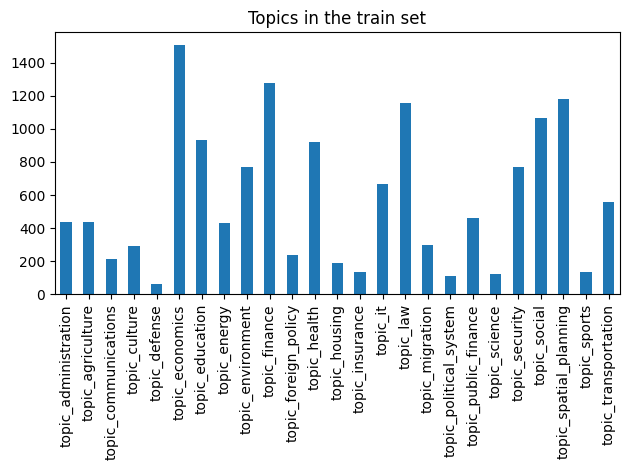

In [17]:
plotting.plot_and_log(
    df_input_train[topic_columns].sum().plot.bar,
    "figures/topics-counts-train.png",
    title="Topics in the train set",
)

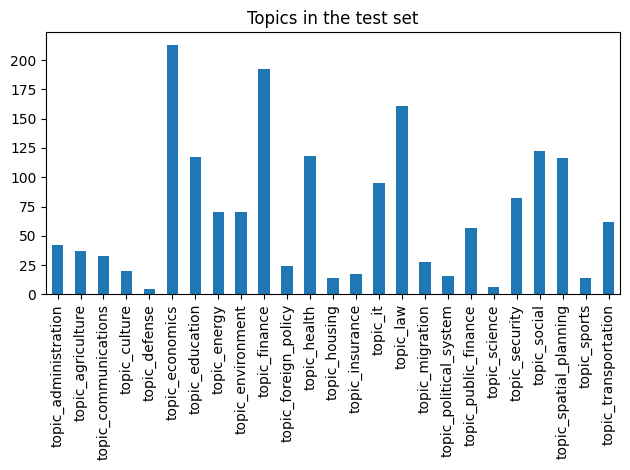

In [18]:
plotting.plot_and_log(
    df_input_test[topic_columns].sum().plot.bar,
    "figures/topics-counts-test.png",
    title="Topics in the test set",
)

# Data exploration

In [20]:
df_input_train.groupby("consultation_identifier").agg({"consultation_topics": "first"}).explode(
    "consultation_topics"
).value_counts()

consultation_topics
economics              515
finance                353
social                 341
health                 331
law                    314
spatial_planning       307
security               279
education              265
public_finance         243
it                     231
environment            229
transportation         198
administration         193
agriculture            163
energy                 150
foreign_policy         132
migration              106
insurance               98
culture                 92
communications          87
housing                 76
science                 52
political_system        51
defense                 40
sports                  40
media                   10
Name: count, dtype: int64

In [27]:
# df_input_train.groupby("consultation_identifier").agg(
#     {"consultation_topics": "first", "consultation_topics_label_source": "first"}
# ).explode("consultation_topics").groupby("consultation_topics")["consultation_topics_label_source"].value_counts()
df_input_train.groupby("consultation_identifier").agg({"consultation_topics_label_source": "first"})[
    "consultation_topics_label_source"
].value_counts()

consultation_topics_label_source
openparldata         1260
manual               1091
organisation_rule       0
Name: count, dtype: int64

# Classification

In [28]:
def create_matrices(df: pd.DataFrame) -> tuple[np.ndarray, pd.DataFrame]:
    x = np.vstack(df["embedding"])
    y = df[topic_columns]
    return x, y


def create_classifier(random_state: int) -> Pipeline:
    return make_pipeline(
        StandardScaler(),
        # PCA(n_components=200, random_state=RANDOM_STATE),
        MultiOutputClassifier(
            LogisticRegression(max_iter=1000),
        ),
    )


X_train, y_train = create_matrices(df_input_train)
X_test, y_test = create_matrices(df_input_test)

groups_train = df_input_train["consultation_identifier"]
groups_test = df_input_test["consultation_identifier"]

print("Train", X_train.shape, y_train.shape)
print("Test", X_test.shape, y_test.shape)

Train (7515, 3072) (7515, 25)
Test (954, 3072) (954, 25)


## CV

In [29]:
classifier_cv = create_classifier(RANDOM_STATE)
classifier_cv

,steps,"[('standardscaler', ...), ('multioutputclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,estimator,LogisticRegre...max_iter=1000)
,n_jobs,None
,penalty,'l2'
,dual,False


In [30]:
cv = stratified_group_split.MultilabelStratifiedGroupKFold(
    n_splits=CV_FOLDS,
    shuffle=True,
    random_state=RANDOM_STATE,
)


def explained_variance_scorer(pipeline: Pipeline, X: Any, y: Any = None) -> np.float64:
    """If PCA is used in the pipeline, include its explained variance in scores."""
    try:
        pca = pipeline.named_steps["pca"]
    except KeyError:
        return np.nan
    explained_variance = np.sum(pca.explained_variance_ratio_)
    return explained_variance


args = {
    "estimator": classifier_cv,
    "X": X_train,
    "y": y_train,
    "groups": groups_train,
    "cv": cv,
    "verbose": 2,
    "n_jobs": -1,
}

print("cross_validate...")
cv_scores_docs = sklearn.model_selection.cross_validate(
    **args,
    scoring={
        "precision": "precision_samples",
        "recall": "recall_samples",
        "f1": "f1_samples",
        "pca_explained_variance": explained_variance_scorer,
    },
)
display(cv_scores_docs)

print("\ncross_val_predict...")
y_cv_predicted_docs = sklearn.model_selection.cross_val_predict(**args)

cross_validate...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[CV] END .................................................... total time=  26.8s
[CV] END .................................................... total time=  27.0s


/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[CV] END .................................................... total time=  27.2s
[CV] END .................................................... total time=  27.3s
[CV] END .................................................... total time=  28.1s


/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.6s finished


{'fit_time': array([26.65113497, 27.10540199, 27.26901484, 26.86111283, 28.07456207]),
 'score_time': array([0.134758  , 0.07563114, 0.06971002, 0.10634804, 0.06630492]),
 'test_precision': array([0.6171748 , 0.66396282, 0.65130279, 0.63679206, 0.66465268]),
 'test_recall': array([0.60761066, 0.63888889, 0.63213163, 0.62626959, 0.60078561]),
 'test_f1': array([0.5724658 , 0.61186855, 0.60075728, 0.59227497, 0.59452542]),
 'test_pca_explained_variance': array([nan, nan, nan, nan, nan])}


cross_val_predict...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.5s finished


In [31]:
print("Per-document scores:")
utils.log_metrics(
    **{k.replace("test_", "cv_") + "_docs": np.mean(v) for k, v in cv_scores_docs.items() if k.startswith("test_")}
)

Per-document scores:
{'cv_f1_docs': 0.5944,
 'cv_pca_explained_variance_docs': nan,
 'cv_precision_docs': 0.6468,
 'cv_recall_docs': 0.6211}


In [32]:
# No need to dive deep into per-document results?
# report = sklearn.metrics.classification_report(
#     y_train, y_cv_predicted_docs, zero_division=np.nan, target_names=topic_columns
# )
# mlflow.log_text(report, "cv_classification_report_docs.txt")
# print(report)

In [33]:
# Convert per-document labels to per-consultation labels
y_cv_true_consultations = data_transformations.group_document_labels_by_consultation(
    consultation_identifiers=groups_train,
    label_names=topic_columns,
    doc_labels=y_train,
)
y_cv_predicted_consultations = data_transformations.group_document_labels_by_consultation(
    consultation_identifiers=groups_train,
    label_names=topic_columns,
    doc_labels=y_cv_predicted_docs,
)

In [34]:
precision, recall, f1, _ = sklearn.metrics.precision_recall_fscore_support(
    y_cv_true_consultations,
    y_cv_predicted_consultations,
    average="samples",
    zero_division=np.nan,
)
scores_consultations = {"cv_precision": precision, "cv_recall": recall, "cv_f1": f1}
print("Per-consultation scores:")
utils.log_metrics(**scores_consultations)

Per-consultation scores:
{'cv_f1': 0.6403, 'cv_precision': 0.683, 'cv_recall': 0.6949}


/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


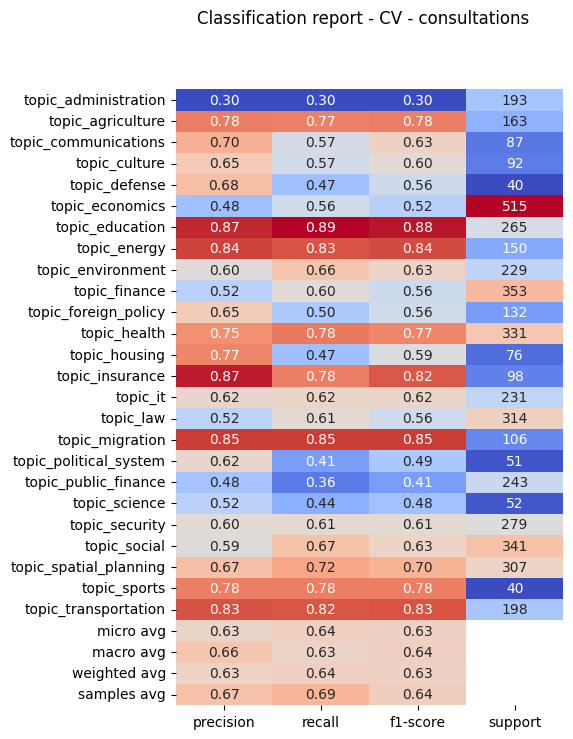

In [35]:
fig = plotting.plot_classification_report_heatmap(
    y_cv_true_consultations.values,
    y_cv_predicted_consultations.values,
    target_names=topic_columns,
)
fig.suptitle("Classification report - CV - consultations")
mlflow.log_figure(fig, "cv_classification_report_consultations.png")
fig

/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


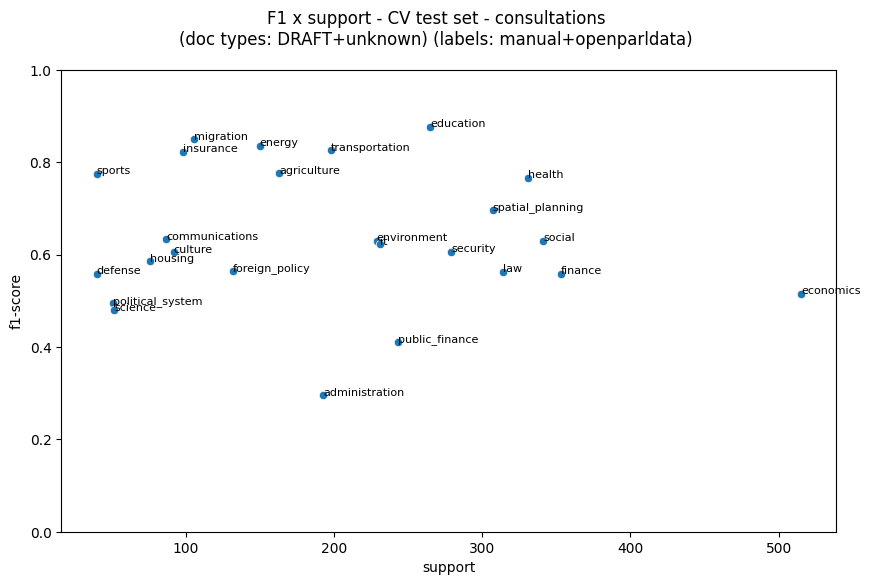

In [36]:
fig = plotting.plot_score_against_support(
    y_cv_true_consultations.values,
    y_cv_predicted_consultations.values,
    target_names=topic_columns,
)
# document_sources = "+".join(sorted(DOCUMENT_SOURCES))
document_types = "+".join(sorted(t if t else "unknown" for t in DOC_TYPES))
label_sources = "+".join(sorted(df_input["consultation_topics_label_source"].unique()))
fig.suptitle(
    "\n".join(
        [
            # f"F1 x support - CV test set - consultations (data: {document_sources})",
            "F1 x support - CV test set - consultations",
            f"(doc types: {document_types}) (labels: {label_sources})",
        ]
    )
)
mlflow.log_figure(fig, "cv_score_against_support_consultations.png")
fig

## Training

2025/07/07 14:53:06 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'DataFrame' object has no attribute 'flatten'
2025/07/07 14:53:34 WARNING mlflow.sklearn.utils: log_loss failed. The metric training_log_loss will not be recorded. Metric error: Found array with dim 3, while dim <= 2 is required.
2025/07/07 14:53:34 WARNING mlflow.sklearn.utils: roc_auc_score failed. The metric training_roc_auc will not be recorded. Metric error: Found array with dim 3, while dim <= 2 is required.
2025/07/07 14:53:35 WARNING mlflow.sklearn.utils: _get_classifier_artifacts.<locals>.plot_confusion_matrix failed. The artifact training_confusion_matrix will not be recorded. Artifact error: multilabel-indicator is not supported
2025/07/07 14:53:38 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


''

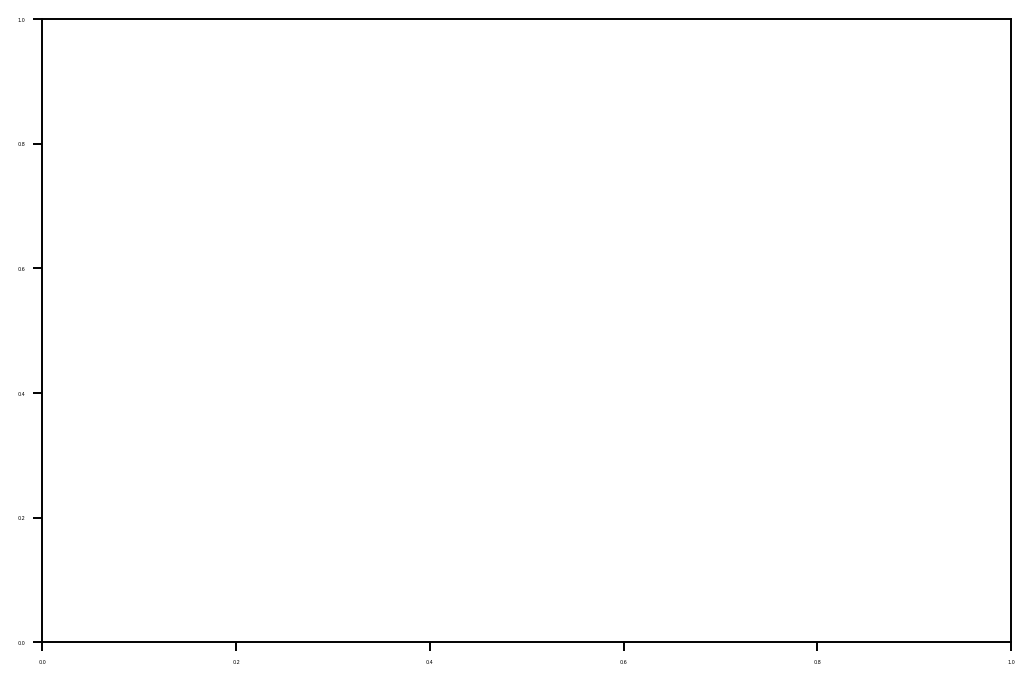

In [37]:
classifier_test = create_classifier(RANDOM_STATE)
classifier_test.fit(X_train, y_train)
;

## Evaluation on the test set

In [38]:
y_test_predicted_docs = classifier_test.predict(X_test)

y_test_true_consultations = data_transformations.group_document_labels_by_consultation(
    consultation_identifiers=df_input_test["consultation_identifier"],
    label_names=topic_columns,
    doc_labels=y_test.values,
)
y_test_predicted_consultations = data_transformations.group_document_labels_by_consultation(
    consultation_identifiers=df_input_test["consultation_identifier"],
    label_names=topic_columns,
    doc_labels=y_test_predicted_docs,
)

In [39]:
precision, recall, f1, _ = sklearn.metrics.precision_recall_fscore_support(
    y_test_true_consultations,
    y_test_predicted_consultations,
    average="samples",
    zero_division=np.nan,
)
scores_consultations = {"test_precision": precision, "test_recall": recall, "test_f1": f1}
print("Per-consultation scores:")
utils.log_metrics(**scores_consultations)

Per-consultation scores:
{'test_f1': 0.6307, 'test_precision': 0.6724, 'test_recall': 0.6927}


/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


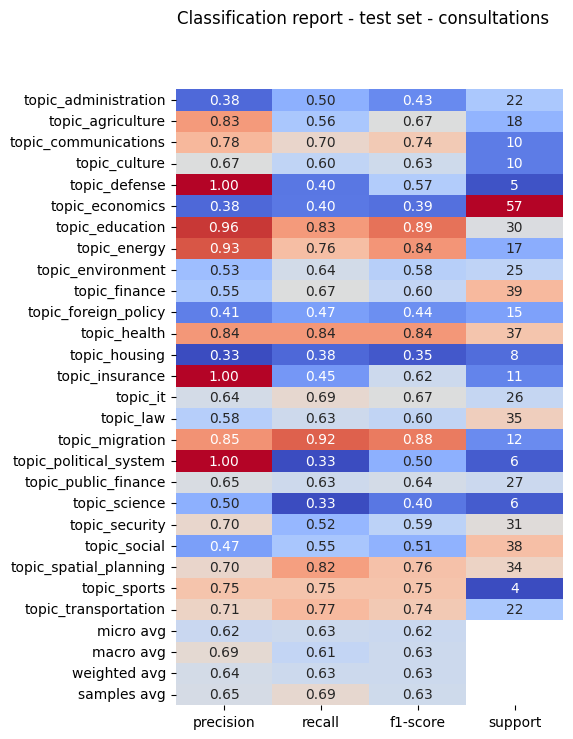

In [40]:
fig = plotting.plot_classification_report_heatmap(
    y_test_true_consultations,
    y_test_predicted_consultations,
    target_names=topic_columns,
)
fig.suptitle("Classification report - test set - consultations")
mlflow.log_figure(fig, "test_classification_report_consultations.png")
display(fig)

***

# End MLflow run

In [41]:
mlflow.end_run()

🏃 View run upbeat-steed-595 at: https://mlflow.ml1.demokratis.ch/#/experiments/5/runs/42fa9954a2134818a26659148041efe0
🧪 View experiment at: https://mlflow.ml1.demokratis.ch/#/experiments/5
